In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np


import warnings
warnings.filterwarnings('ignore')
from src.data_processing.loader import load_feature_vector_data
import random
from src.visualisation.price_plotter import plot_token_price

In [2]:
# Read data
df = load_feature_vector_data()

# Select features for clustering
features = ['trade_frequency', 'average_trade_size', 'unique_traders',
            'max_market_cap', 'initial_liquidity', 'price_volatility',
            'total_trades', 'lifetime_seconds']

# Create feature matrix
X = df[features]

# Display basic statistics
X.describe()

# %%
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=features)


  File "c:\Users\matth\Uni Work\CM3203 - Individual Project\Project Environment\CM3203-Venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 550, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1028, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\matth\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1540, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


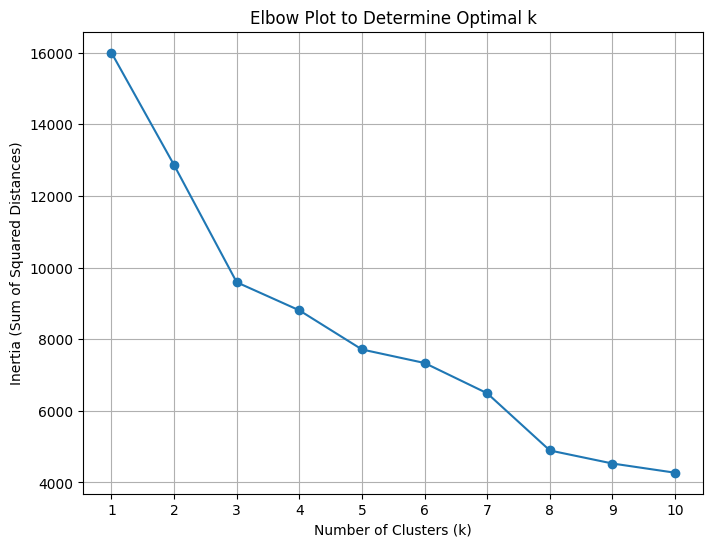

In [3]:
# Use elbow plot to find optimal k value

# Range of k values to test (you can adjust the range if needed)
k_range = range(1, 11)  # For example, from 1 to 10 clusters

# List to store the inertia values for each k
inertia = []

# Loop through each k value and compute KMeans
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled_df)  # Fit the KMeans model to the scaled data
    inertia.append(kmeans.inertia_)  # Append the inertia (sum of squared distances)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Plot to Determine Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.xticks(k_range)
plt.grid(True)
plt.show()


In [ ]:
# Picking 3 as optimal k
best_k = 3
# Now let's visualize and analyze this optimal clustering
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_),
                             columns=features)

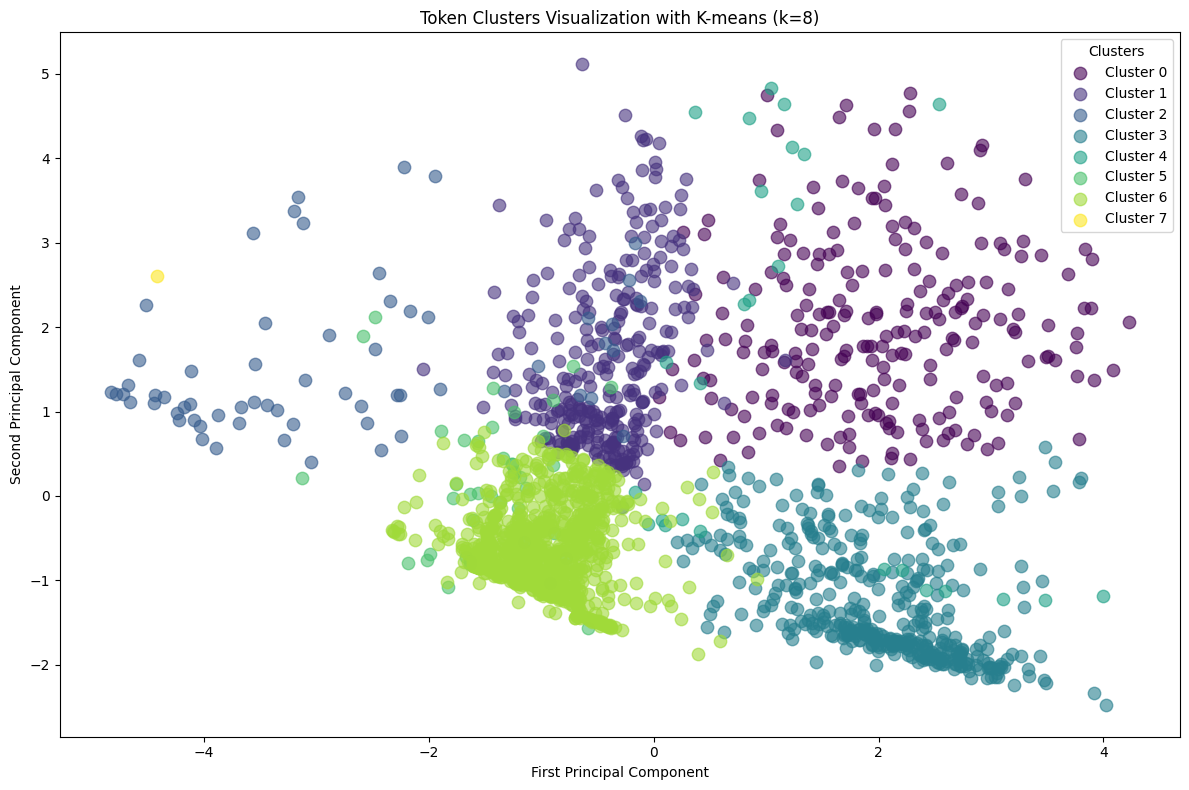

In [21]:
from sklearn.decomposition import PCA

# Visualize the clusters with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Define a color map for the clusters
unique_clusters = np.unique(df['cluster'])
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each cluster with its corresponding color
for i, cluster in enumerate(unique_clusters):
    cluster_points = X_pca[df['cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                color=colors[i], label=f'Cluster {cluster}', alpha=0.6, s=80)

# Add labels and title
plt.title(f'Token Clusters Visualization with K-means (k={best_k})')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(title="Clusters")
plt.tight_layout()
plt.show()


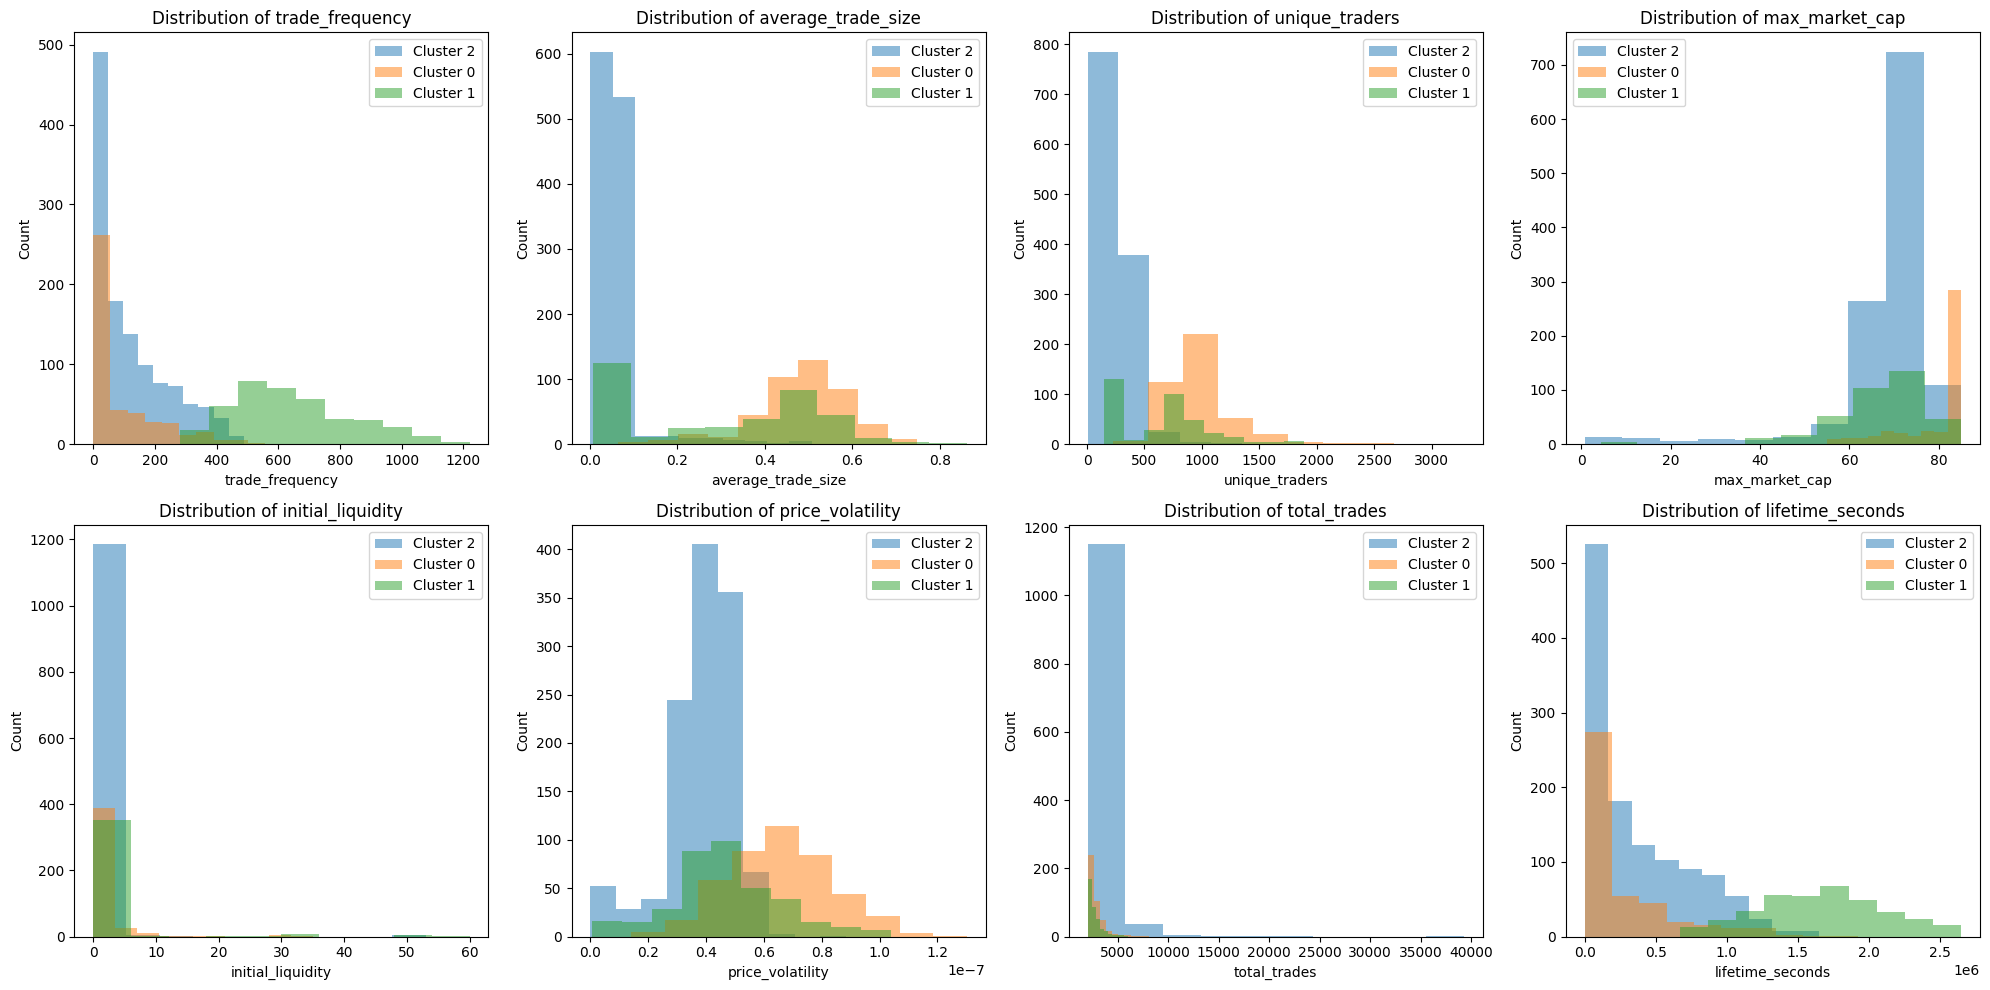

In [6]:
# Feature distributions by cluster
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(features):
    for cluster in df['cluster'].unique():
        subset = df[df['cluster'] == cluster]
        axes[i].hist(subset[feature], alpha=0.5, label=f'Cluster {cluster}')
    
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [7]:
# Create a summary of each cluster's characteristics
cluster_profiles = []

for i in range(best_k):
    cluster_tokens = df[df['cluster'] == i]
    
    # Get the top distinguishing features for this cluster
    cluster_center = kmeans.cluster_centers_[i]
    # Calculate the distance from the global mean for each feature
    global_mean = np.mean(X_scaled, axis=0)
    feature_deviations = cluster_center - global_mean
    # Get the features with the largest absolute deviation
    sorted_features = np.argsort(-np.abs(feature_deviations))
    distinguishing_features = [features[j] for j in sorted_features[:3]]
    
    profile = {
        'Cluster': i,
        'Size': len(cluster_tokens),
        'Percentage': f"{100 * len(cluster_tokens) / len(df):.1f}%",
        'Top Features': distinguishing_features,
        'Description': ""
    }
    
    # Create a qualitative description
    description = f"Cluster {i} is characterized by "
    for j, feature in enumerate(distinguishing_features):
        direction = "high" if feature_deviations[sorted_features[j]] > 0 else "low"
        description += f"{direction} {feature}"
        if j < len(distinguishing_features) - 1:
            description += ", "
            
    profile['Description'] = description
    cluster_profiles.append(profile)
    
# Create a DataFrame with cluster profiles
profiles_df = pd.DataFrame(cluster_profiles)
print("\nCluster Profiles:")

# Set pandas display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Print the complete DataFrame
print(profiles_df[['Cluster', 'Size', 'Percentage', 'Top Features', 'Description']])

# Reset to defaults after printing
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')


Cluster Profiles:
   Cluster  Size Percentage  \
0        0   436      21.8%   
1        1   368      18.4%   
2        2  1196      59.8%   

                                              Top Features  \
0   [average_trade_size, unique_traders, price_volatility]   
1  [trade_frequency, lifetime_seconds, average_trade_size]   
2   [average_trade_size, unique_traders, price_volatility]   

                                                                                          Description  
0   Cluster 0 is characterized by high average_trade_size, high unique_traders, high price_volatility  
1  Cluster 1 is characterized by high trade_frequency, high lifetime_seconds, high average_trade_size  
2      Cluster 2 is characterized by low average_trade_size, low unique_traders, low price_volatility  


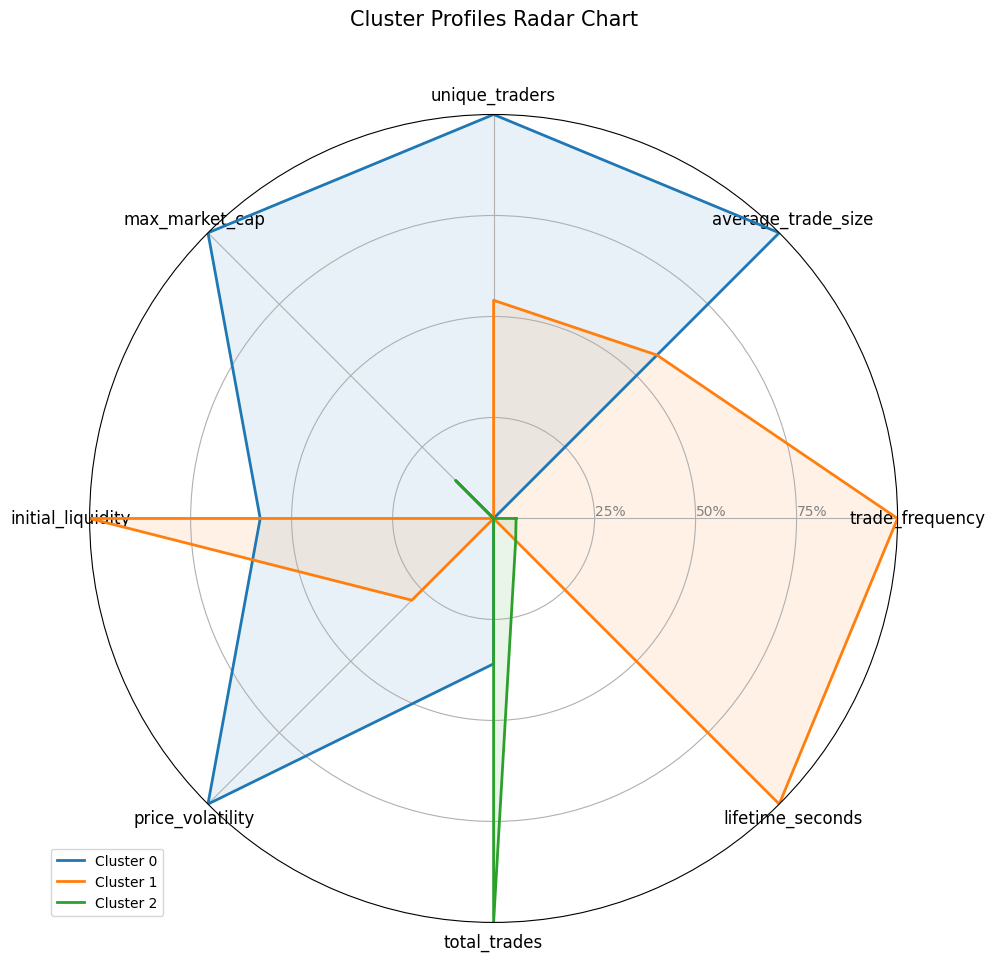

In [8]:
# Visualize the final clusters with a radar chart
def plot_radar_chart(cluster_centers, features, n_clusters):
    # Number of variables
    N = len(features)
    
    # What will be the angle of each axis in the plot (divide the plot into equal parts)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw one axis per variable and add labels
    plt.xticks(angles[:-1], features, size=12)
    
    # Draw the y-axis labels (0-100%)
    ax.set_rlabel_position(0)
    plt.yticks([0.25, 0.5, 0.75], ["25%", "50%", "75%"], color="grey", size=10)
    plt.ylim(0, 1)
    
    # Plot each cluster
    for i in range(n_clusters):
        # Normalize the cluster center values for radar chart (0-1 scale)
        values = cluster_centers.iloc[i].values.tolist()
        min_vals = cluster_centers.min()
        max_vals = cluster_centers.max()
        normalized_values = [(val - min_val) / (max_val - min_val) if max_val > min_val else 0.5 
                           for val, min_val, max_val in zip(values, min_vals, max_vals)]
        
        normalized_values += normalized_values[:1]  # Close the loop
        
        # Plot values
        ax.plot(angles, normalized_values, linewidth=2, linestyle='solid', label=f"Cluster {i}")
        ax.fill(angles, normalized_values, alpha=0.1)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Cluster Profiles Radar Chart", size=15, y=1.1)
    
    plt.tight_layout()
    plt.show()

# Plot radar chart
plot_radar_chart(cluster_centers, features, best_k)

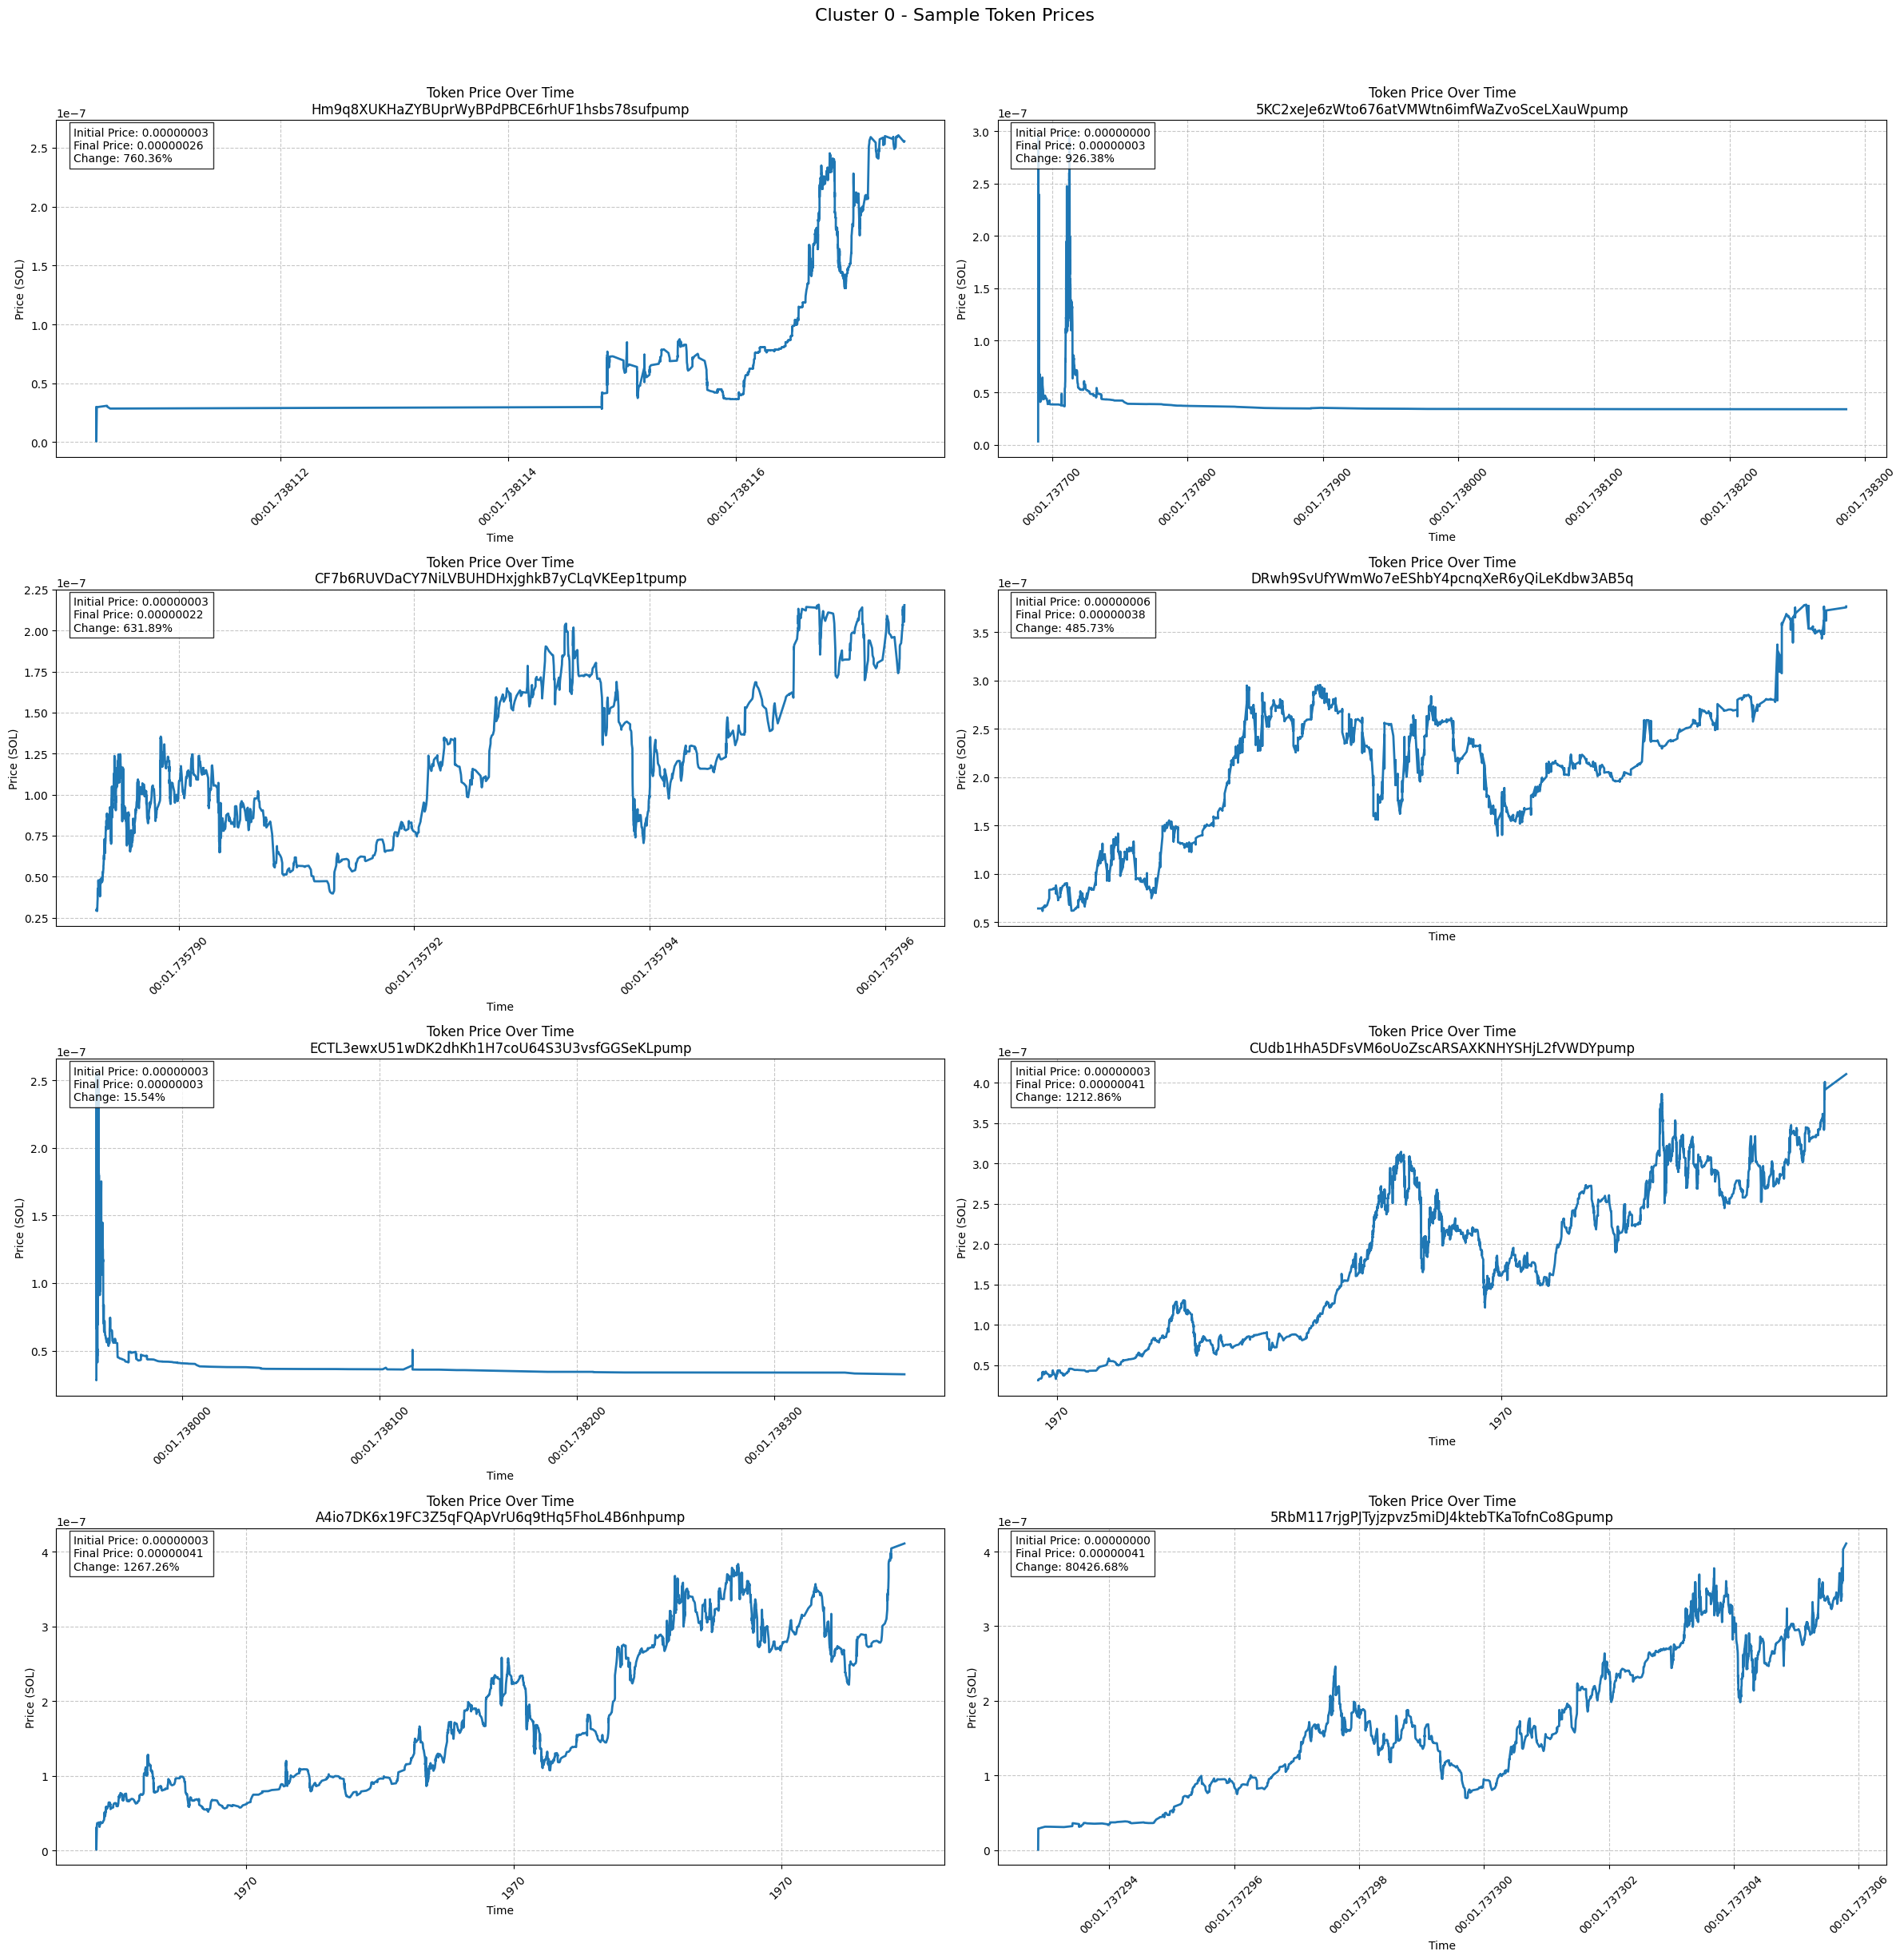

Created price plot for 8 tokens from cluster 0


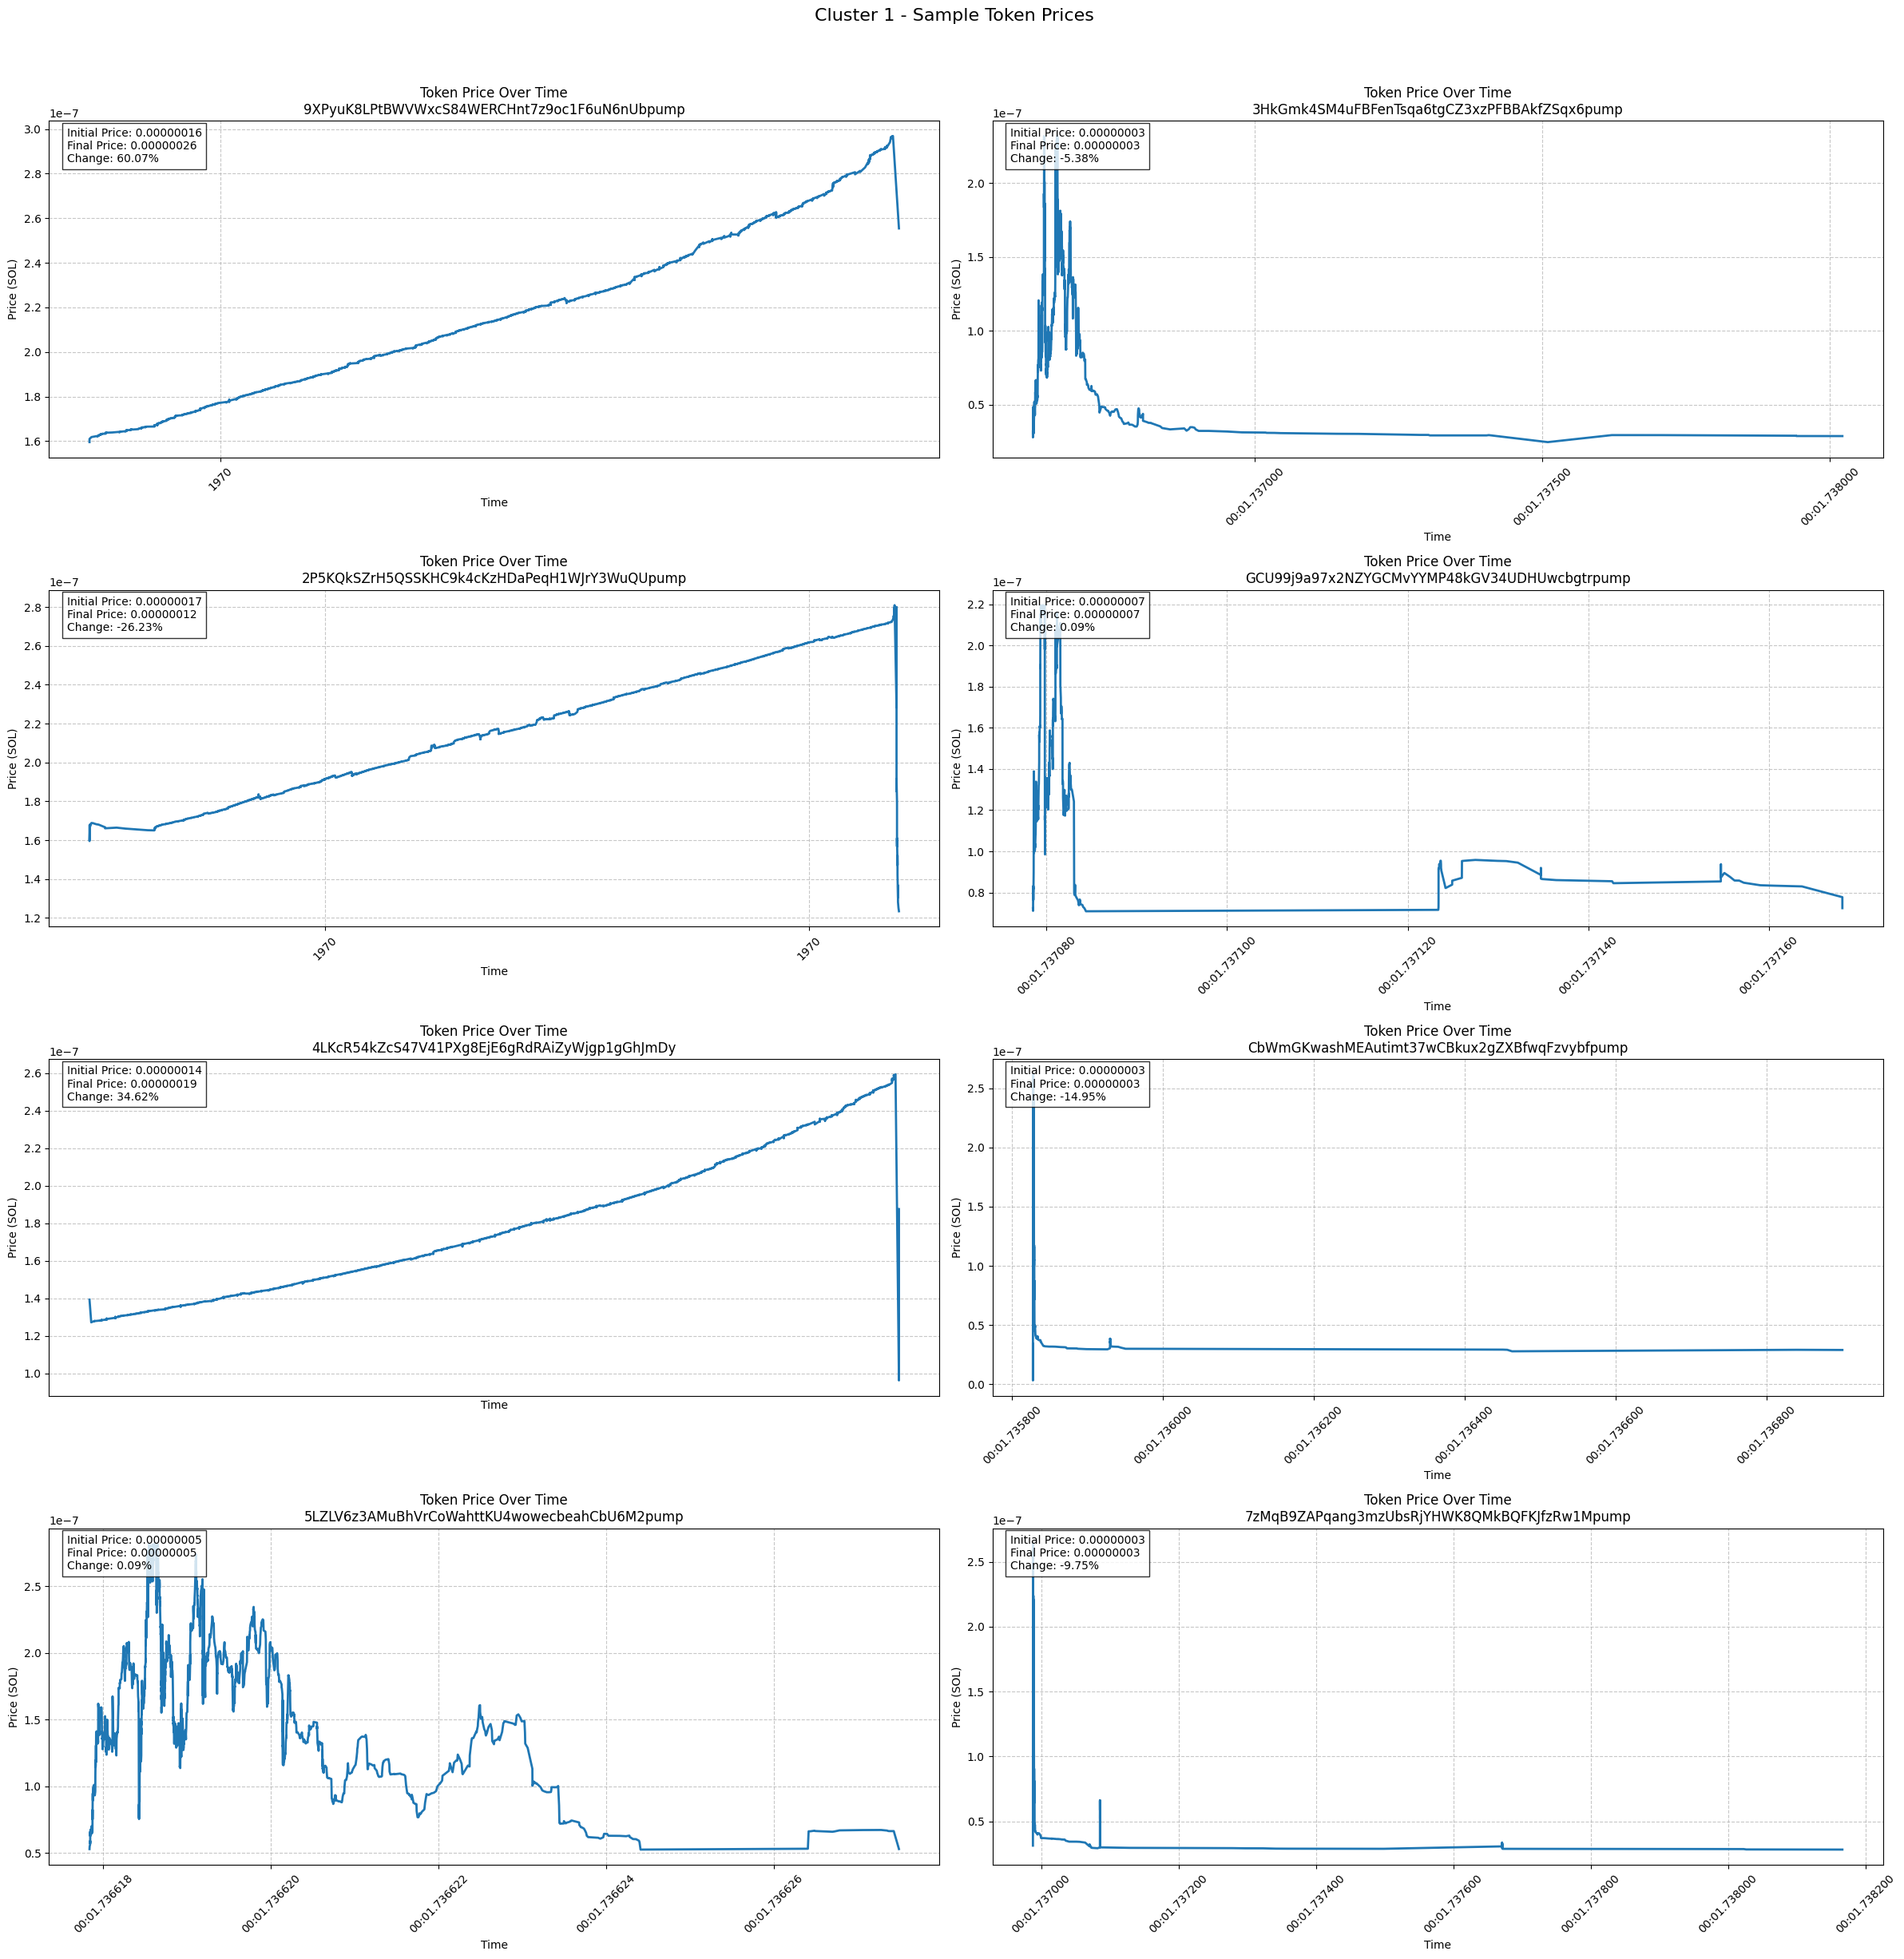

Created price plot for 8 tokens from cluster 1


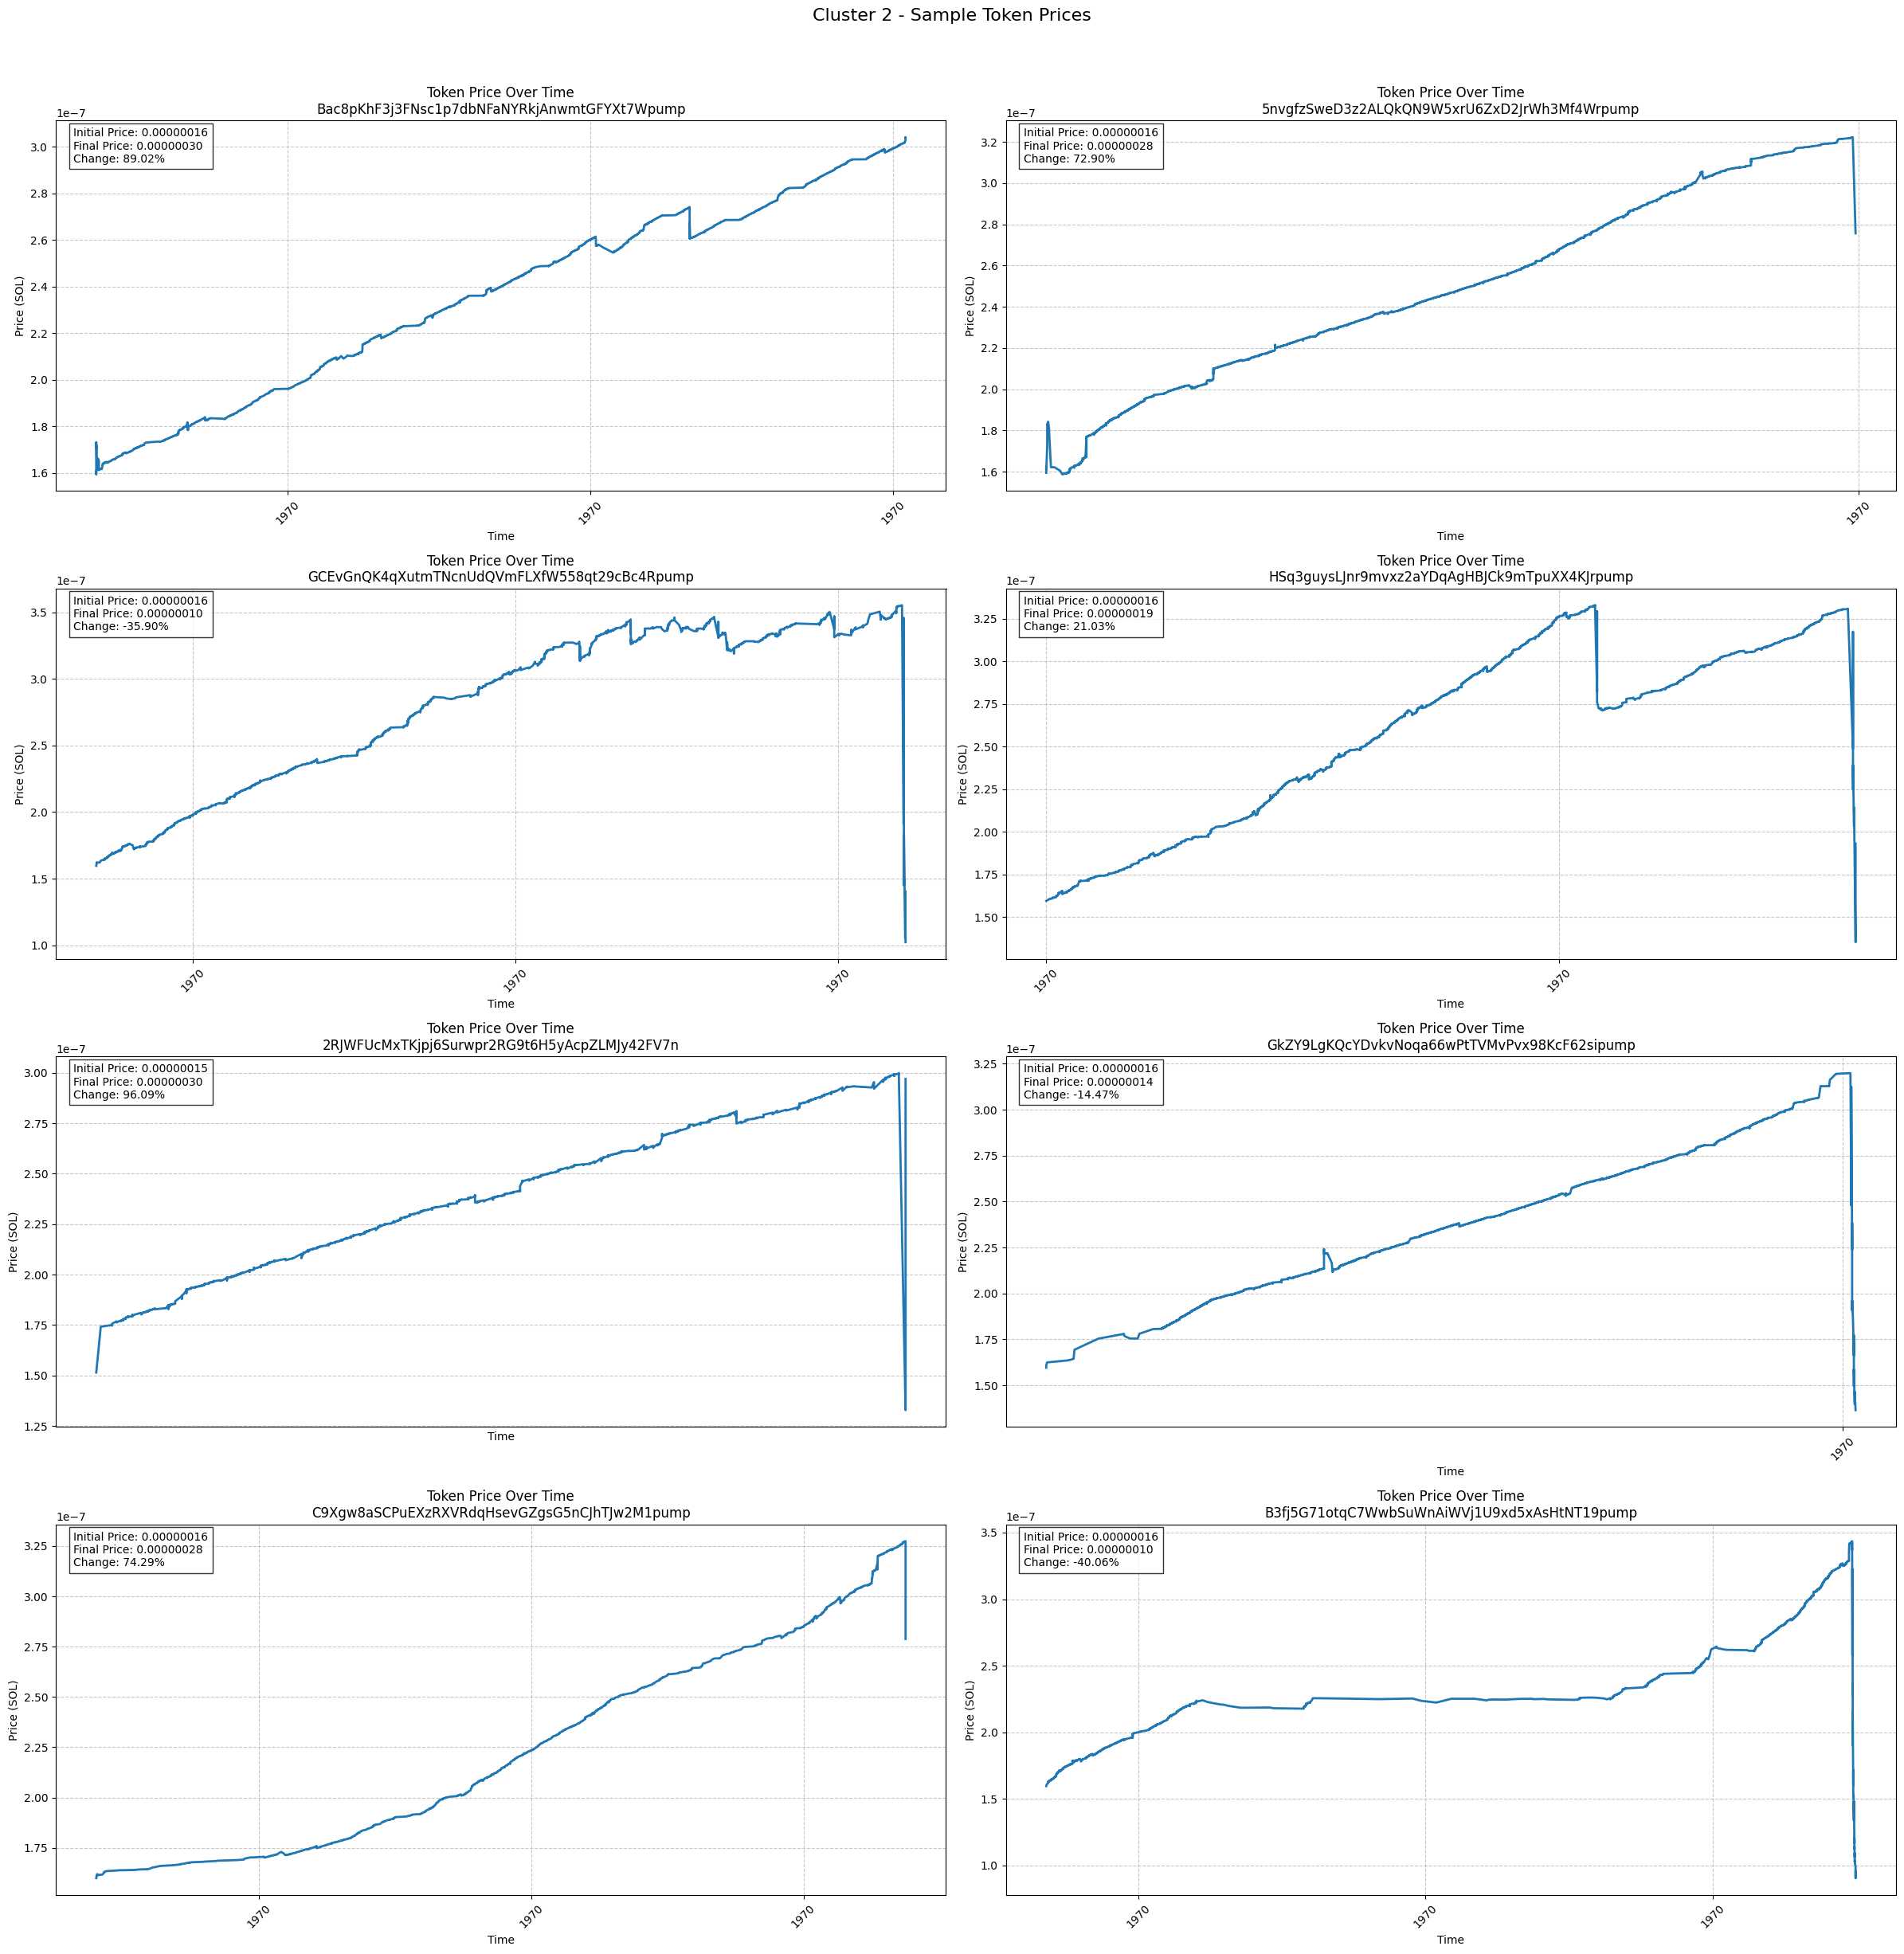

Created price plot for 8 tokens from cluster 2


In [9]:
# For each cluster, plot 8 random tokens
for cluster_id in range(best_k):
    # Filter the dataframe to get only tokens in this cluster
    cluster_tokens = df[df['cluster'] == cluster_id]
    
    # Make sure we don't try to sample more tokens than we have
    sample_size = min(8, len(cluster_tokens))
    
    if sample_size > 0:
        # Sample 8 random tokens (or fewer if the cluster has less than 8)
        random_tokens = cluster_tokens.sample(n=sample_size, random_state=42)
        
        # Get the token addresses
        token_addresses = random_tokens['token_address'].tolist()
        
        # Plot the tokens
        plot_title = f"Cluster {cluster_id} - Sample Token Prices"
        plot_token_price(token_addresses, title=plot_title)
        
        print(f"Created price plot for {sample_size} tokens from cluster {cluster_id}")
    else:
        print(f"Cluster {cluster_id} is empty, no plot created")

In [10]:
# Cluster 2 seems to contain legit tokens

# Save tokens to file
with open("k_means_tokens.txt", "w") as f:
    for token in df[df['cluster'] == 2]['token_address'].tolist():
        f.write(token + "\n")
